In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Loading database
df_train = pd.read_csv("dataset/UNSW_NB15_training-set.csv", low_memory=False)
df_test = pd.read_csv("dataset/UNSW_NB15_testing-set.csv", low_memory=False)

df_train = df_train.drop(["id", "attack_cat"], axis=1)
df_test = df_test.drop(["id", "attack_cat"], axis=1)



In [5]:
# Visualizing df (train) info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [6]:

df_train.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


In [7]:
df_test.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,0


In [8]:
# Object (categoric) columns

cat_cols = df_train.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['proto', 'service', 'state'], dtype='object')


In [9]:
# Selecting columns
X_train = df_train.iloc[:, :-1]
y_train = df_train['label']

X_test = df_test.iloc[:, :-1]
y_test = df_test['label']


In [10]:
print(X_test)

            dur proto service state  spkts  dpkts  sbytes  dbytes  \
0      0.000011   udp       -   INT      2      0     496       0   
1      0.000008   udp       -   INT      2      0    1762       0   
2      0.000005   udp       -   INT      2      0    1068       0   
3      0.000006   udp       -   INT      2      0     900       0   
4      0.000010   udp       -   INT      2      0    2126       0   
...         ...   ...     ...   ...    ...    ...     ...     ...   
82327  0.000005   udp       -   INT      2      0     104       0   
82328  1.106101   tcp       -   FIN     20      8   18062     354   
82329  0.000000   arp       -   INT      1      0      46       0   
82330  0.000000   arp       -   INT      1      0      46       0   
82331  0.000009   udp       -   INT      2      0     104       0   

                rate  sttl  ...  ct_dst_ltm  ct_src_dport_ltm  \
0       90909.090200   254  ...           1                 1   
1      125000.000300   254  ...          

In [11]:
# Visualizing columns from df(train)
cat_cols_train = X_train.select_dtypes(include=['object']).columns
num_cols_train = X_train.select_dtypes(exclude=['object']).columns
print(f"Categoric columns: {len(cat_cols_train)}")
print(f"Numeric columns: {len(num_cols_train)}")

Categoric columns: 3
Numeric columns: 39


In [12]:
# Visualizing columns from df(test)
cat_cols_test = X_test.select_dtypes(include=['object']).columns
num_cols_test = X_test.select_dtypes(exclude=['object']).columns
print(f"Categoric columns: {len(cat_cols_train)}")
print(f"Numeric columns: {len(num_cols_train)}")

Categoric columns: 3
Numeric columns: 39


In [13]:
normal = df_train.loc[df_train["label"] == 0]
malicious = df_train.loc[df_train["label"] == 1]

normal_test = df_test.loc[df_test["label"] == 0]
malicious_test = df_test.loc[df_test["label"] == 1]

print(f"There is {len(normal)} normal traffic and {len(malicious)} malicious traffic (train data)")
print(
    f"There is {len(normal_test)} normal traffic and {len(malicious_test)} malicious traffic (test data)")

There is 56000 normal traffic and 119341 malicious traffic (train data)
There is 37000 normal traffic and 45332 malicious traffic (test data)


In [14]:
preprocessor_train = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_train),
        ('num', RobustScaler(), num_cols_train)
    ]
)

pipeline_train = Pipeline(steps=[
    ('preprocessor', preprocessor_train)
])

X_train_transformed = pipeline_train.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

X_test_transformed = pipeline_train.transform(X_test)


print(f"Shape dos dados de treino após SMOTE: {X_resampled.shape}")
print(f"Shape dos dados de teste após transformação: {X_test_transformed.shape}")

Shape dos dados de treino após SMOTE: (238682, 194)
Shape dos dados de teste após transformação: (82332, 194)


In [21]:
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

X_train_resampled = X_train_resampled.toarray()
X_val_resampled = X_val_resampled.toarray()

y_train_resampled = y_train_resampled.astype(np.float32)
y_val_resampled = y_val_resampled.astype(np.float32).to_numpy()

X_test_transformed = X_test_transformed.astype(np.float32)

y_test_transformed = y_test.astype(np.float32)

print(f"Train length: {X_train_resampled.shape}")
print(f"Val length: {X_val_resampled.shape}")
print(f"Test length: {X_test_transformed.shape}")

Train length: (167077, 194)
Val length: (71605, 194)
Test length: (82332, 194)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:

train_data = TensorDataset(torch.tensor(X_train_resampled, dtype=torch.float32).to(device),
                           torch.tensor(y_train_resampled, dtype=torch.float32).view(-1, 1).to(device))

test_data = TensorDataset(torch.tensor(X_test_transformed, dtype=torch.float32).to(device),
                          torch.tensor(y_test_transformed, dtype=torch.float32).view(-1, 1).to(device))

val_data = TensorDataset(torch.tensor(X_val_resampled, dtype=torch.float32).to(device),
                         torch.tensor(y_val_resampled, dtype=torch.float32).view(-1, 1).to(device))

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [46]:

class MainNetwork(nn.Module):
    def __init__(self):
        super(MainNetwork, self).__init__()

        self.fc1 = nn.Linear(194, 194)
        self.fc2 = nn.Linear(194, 168)
        self.fc3 = nn.Linear(168, 124)
        self.fc4 = nn.Linear(124, 96)
        self.fc5 = nn.Linear(96, 48)
        self.fc6 = nn.Linear(48, 24)
        self.fc7 = nn.Linear(24, 1)

    
        self.bn1 = nn.BatchNorm1d(194)  
        self.bn2 = nn.BatchNorm1d(168)  
        self.bn3 = nn.BatchNorm1d(124)  
        self.bn4 = nn.BatchNorm1d(96)
        self.bn5 = nn.BatchNorm1d(48)
        self.bn6 = nn.BatchNorm1d(24)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.bn1(self.relu(self.fc1(x))) 
        x = self.dropout(x)

        x = self.bn2(self.relu(self.fc2(x)))  
        x = self.dropout(x)

        x = self.bn3(self.relu(self.fc3(x)))  
        x = self.dropout(x)

        x = self.bn4(self.relu(self.fc4(x)))  
        x = self.dropout(x)

        x = self.bn5(self.relu(self.fc5(x)))
        x = self.dropout(x)

        x = self.bn6(self.relu(self.fc6(x)))
        x = self.dropout(x)

        x = self.fc7(x)

        return x

In [54]:
# Model, loss function and optimizer

model = MainNetwork().to(device)
pos_weight = torch.tensor([5.0]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [65]:
epochs = 70

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(
            device).float().view(-1, 1)

        optimizer.zero_grad()

        y_pred = model(inputs)
        loss = criterion(y_pred, labels)

        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(y_pred)
        predicted = (probs > 0.55).float()

        correct = (predicted == labels).float()
        acc = correct.sum() / len(correct)

        running_loss += loss.item()
        running_acc += acc.item()

    avg_loss = running_loss / len(train_loader)
    avg_acc = running_acc / len(train_loader)

    # Validation 
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():  
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(
                device).float().view(-1, 1)

            y_pred = model(inputs)
            loss = criterion(y_pred, labels)

            probs = torch.sigmoid(y_pred)
            predicted = (probs > 0.51).float()

            correct = (predicted == labels).float()
            acc = correct.sum() / len(correct)

            val_loss += loss.item()
            val_acc += acc.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_acc * 100:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc * 100:.2f}%")

Epoch [1/70], Train Loss: 0.6353, Train Accuracy: 93.88%, Validation Loss: 0.5675, Validation Accuracy: 94.57%
Epoch [2/70], Train Loss: 0.6357, Train Accuracy: 93.90%, Validation Loss: 0.6047, Validation Accuracy: 94.05%
Epoch [3/70], Train Loss: 0.6325, Train Accuracy: 93.97%, Validation Loss: 0.5798, Validation Accuracy: 94.48%
Epoch [4/70], Train Loss: 0.6334, Train Accuracy: 93.96%, Validation Loss: 0.6220, Validation Accuracy: 93.29%
Epoch [5/70], Train Loss: 0.6317, Train Accuracy: 93.91%, Validation Loss: 0.5750, Validation Accuracy: 94.51%
Epoch [6/70], Train Loss: 0.6284, Train Accuracy: 94.02%, Validation Loss: 0.5748, Validation Accuracy: 94.56%
Epoch [7/70], Train Loss: 0.6309, Train Accuracy: 93.96%, Validation Loss: 0.5651, Validation Accuracy: 94.56%
Epoch [8/70], Train Loss: 0.6328, Train Accuracy: 93.98%, Validation Loss: 0.5714, Validation Accuracy: 94.59%
Epoch [9/70], Train Loss: 0.6329, Train Accuracy: 93.99%, Validation Loss: 0.5805, Validation Accuracy: 94.43%
E

In [73]:
# Testing
model.eval()

with torch.no_grad():
    test_loss = 0.0
    test_acc = 0.0
    y_pred_test = []
    y_true_test = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(
            device).float().view(-1, 1)

        y_pred = model(inputs)

        loss = criterion(y_pred, labels)
        test_loss += loss.item()

        probs = torch.sigmoid(y_pred) 

        predicted = (probs > 0.55).float()

        correct = (predicted == labels).float()
        acc = correct.sum() / len(correct)
        test_acc += acc.item()


        y_pred_test.extend(predicted.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())


    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)

    print(
        f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc * 100:.2f}%")

Test Loss: 1.0525, Test Accuracy: 90.35%


In [68]:
y_pred_test = np.array(y_pred_test).flatten()
y_true_test = np.array(y_true_test).flatten()

In [69]:

false_neg = np.sum((y_pred_test == 0) & (y_true_test == 1))
false_pos = np.sum((y_pred_test == 1) & (y_true_test == 0))
incorrect = np.sum(y_pred_test != y_true_test)
total = len(y_true_test)

accuracy = accuracy_score(y_true_test, y_pred_test)
inaccuracy = incorrect / total

print(f'Accuracy: {accuracy * 100:.4f}%')
print(f'Incorrect: {inaccuracy * 100:.4f}%')
print(f'False negatives: {false_neg / incorrect:.4f}')
print(f'False positives: {false_pos / incorrect:.4f}')
print(f'False negatives/total: {false_neg / total:.4f}')


Accuracy: 90.3804%
Incorrect: 9.6196%
False negatives: 0.2744
False positives: 0.7256
False negatives/total: 0.0264


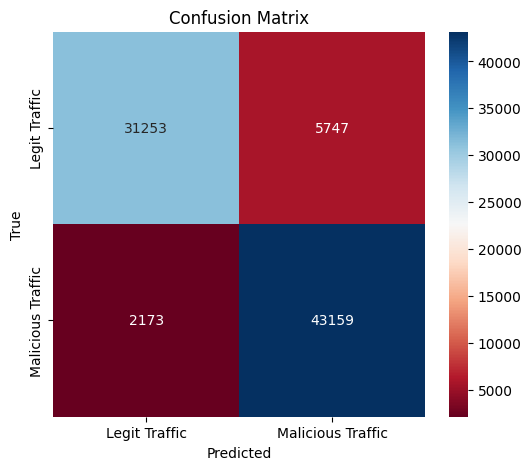

In [70]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu', xticklabels=[
            'Legit Traffic', 'Malicious Traffic'], yticklabels=['Legit Traffic', 'Malicious Traffic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
torch.save(model.state_dict(), "model.pth")

In [72]:
joblib.dump(pipeline_train, "preprocessor.pkl")

['preprocessor.pkl']